In [1]:
import psycopg2
# to install from commandline: conda install -c anaconda psycopg2
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
#need to be connected to vpn
#server information is stored in config.py file 
import config 
conn = psycopg2.connect(dbname=config.dbname, user=config.user, host=config.host, port=config.port,password=config.password)
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciv" + ';'

How do people find dialysis in MIMIC? 


From https://github.com/geickelb/mimiciii-antibiotics-opensource/blob/master/notebooks/03-clinical_variables_initial.ipynb

Renal replacement therapy
the sql code for this was not equipped to join all of the charttimes together. so i decided to do it in python below. the rrt_all_df code above was only a 1 or 0 if patient had RRT during their entire icu stay.

step 1: run all sql codes
2: filter on only the t_0 to t_72 hour rows
3: filter on the 1223 patients who have a positive value
4: get the earliest incidence of rrt for each 1223 patients.

In [ ]:
def rrt_runmerge():
    """
    wrapping a lot of scripting into a function. grabs the 5 different rrt datas, filters them to timewindow, and merges them into 1 dataframe.
    """
    global date,folder, patient_df,lower_window, upper_window, time_var, time_var, time_col
    
    ###5 sql queries to grab raw data
    
    #mv_ce
    f = open(str(repository_path)+'/src/SQL/rtt_mv_ce.sql' , 'r')  
    rrtSQL_mv_ce = f.read()
    rrtSQL_mv_ce_sql = query_schema + rrtSQL_mv_ce.format(tuple(patients))
    rrtSQL_mv_ce_df=pd.read_sql_query(rrtSQL_mv_ce_sql,conn)    
    #cv
    f = open(str(repository_path)+'/src/SQL/rtt_cv.sql' , 'r') 
    rrtSQL_cv = f.read()
    rrtSQL_cv_sql = query_schema + rrtSQL_cv.format(tuple(patients))
    rrtSQL_cv_df=pd.read_sql_query(rrtSQL_cv_sql,conn)          
    #mv_ie
    f = open(str(repository_path)+'/src/SQL/rtt_mv_ie.sql' , 'r') 
    rrtSQL_mv_ie = f.read()
    rrtSQL_mv_ie_sql = query_schema + rrtSQL_mv_ie.format(tuple(patients))
    rrtSQL_mv_ie_df=pd.read_sql_query(rrtSQL_mv_ie_sql,conn)      
    rrtSQL_mv_ie_df['charttime']= rrtSQL_mv_ie_df['starttime']
    rrtSQL_mv_ie_df=rrtSQL_mv_ie_df.drop('starttime', axis=1)
    #mv_de
    f = open(str(repository_path)+'/src/SQL/rtt_mv_de.sql' , 'r') 
    rrtSQL_mv_de = f.read()
    rrtSQL_mv_de_sql = query_schema + rrtSQL_mv_de.format(tuple(patients))
    rrtSQL_mv_de_df=pd.read_sql_query(rrtSQL_mv_de_sql,conn)      
    #mv_pe
    f = open(str(repository_path)+'/src/SQL/rtt_mv_pe.sql' , 'r') 
    rrtSQL_mv_pe = f.read()
    rrtSQL_mv_pe_sql = query_schema + rrtSQL_mv_pe.format(tuple(patients))
    rrtSQL_mv_pe_df=pd.read_sql_query(rrtSQL_mv_pe_sql,conn)          
    rrtSQL_mv_pe_df['charttime']= rrtSQL_mv_pe_df['starttime']
    rrtSQL_mv_pe_df=rrtSQL_mv_pe_df.drop('starttime', axis=1)
    
    ### timewindow filtering

    def hour_72_window_rrt(df, final_pt_df2,timecol='charttime',time_var='t_0', lower_window=0, upper_window=3 ):
        ##modified to make more generalizable to easily accomidate PA cohort but default to my origional cohort.
        ##filters rrt to within timewindow  between timecol- time_var

        df= pd.merge(final_pt_df2[['icustay_id',time_var]], df, left_on= 'icustay_id', right_on = 'icustay_id', how='left') #n=240317
        df['delta']= pd.to_datetime(df[timecol]) - pd.to_datetime(df[time_var])
        df_after_t0= df.loc[df.loc[:,'delta']>= pd.Timedelta(days=lower_window),:]
        df_after_t0= df_after_t0.loc[df_after_t0.loc[:,'delta']<= pd.Timedelta(days=upper_window),:] 
        #df_after_t0= df_after_t0.loc[df_after_t0.loc[:,'rrt']==1,:].groupby('icustay_id')['charttime'].min()
        return(pd.DataFrame(df_after_t0))#.reset_index())
    
    rrtSQL_mv_ce_pt =hour_72_window_rrt(rrtSQL_mv_ce_df, patient_df, timecol=time_col,time_var=time_var, lower_window=lower_window,upper_window=upper_window)
    rrtSQL_cv_pt =hour_72_window_rrt(rrtSQL_cv_df, patient_df, timecol=time_col,time_var=time_var, lower_window=lower_window,upper_window=upper_window)
    rrtSQL_mv_ie_pt =hour_72_window_rrt(rrtSQL_mv_ie_df, patient_df, timecol=time_col,time_var=time_var, lower_window=lower_window,upper_window=upper_window)
    rrtSQL_mv_de_pt =hour_72_window_rrt(rrtSQL_mv_de_df, patient_df, timecol=time_col,time_var=time_var, lower_window=lower_window,upper_window=upper_window)
    rrtSQL_mv_pe_pt =hour_72_window_rrt(rrtSQL_mv_pe_df, patient_df, timecol=time_col,time_var=time_var, lower_window=lower_window,upper_window=upper_window)
    
    ### merging all 5 filtered rrt_df together
    
    def rrt_merging(rrtSQL_mv_ce_pt, rrtSQL_cv_pt, rrtSQL_mv_ie_pt, rrtSQL_mv_de_pt, rrtSQL_mv_pe_pt, timecol='charttime',time_var='t_0'):
        ###returns an aggregate y/n of if patient had positive rrt within timewindow. 

        rrt_merged_pt= pd.concat([rrtSQL_mv_ce_pt, rrtSQL_cv_pt, rrtSQL_mv_ie_pt, rrtSQL_mv_de_pt, rrtSQL_mv_pe_pt])

        #making a 1 if has positive rrt within timewindow:
        rrt_merged_pt= pd.DataFrame(rrt_merged_pt.loc[rrt_merged_pt.loc[:,'rrt']==1,:].groupby('icustay_id')[timecol].min().reset_index())
        rrt_merged_pt['rrt']=1

        rrt_merged_allpt_df= pd.merge(final_pt_df2[['icustay_id',time_var]], rrt_merged_pt, left_on= 'icustay_id', right_on = 'icustay_id', how='left') #n=240317
        rrt_merged_allpt_df=rrt_merged_allpt_df.rename(index=str, columns={timecol:"first_charttime"})

        rrt_merged_allpt_df['uom']='category' #adding a uom category
        rrt_merged_allpt_df.loc[rrt_merged_allpt_df.loc[:,'rrt'].isnull(),'rrt']='0'

        return(rrt_merged_allpt_df)


    rrt_merged_allpt_df= rrt_merging(rrtSQL_mv_ce_pt, rrtSQL_cv_pt, rrtSQL_mv_ie_pt, rrtSQL_mv_de_pt, rrtSQL_mv_pe_pt, timecol=time_col,time_var=time_var)
    return(rrt_merged_allpt_df)

rrt_merged_allpt_df= rrt_runmerge()
filter_subset_save(rrt_merged_allpt_df, savename="rrt_merged", save=save_boolean, return_df=False, time_filter_override=True)
del(rrt_merged_allpt_df)

In [ ]:
rtt_cv.sql

 select ie.icustay_id, ce.charttime
    , (
        case
          when ce.itemid in (152,148,149,146,147,151,150) and value is not null then 1
          when ce.itemid in (229,235,241,247,253,259,265,271) and value = 'Dialysis Line' then 1
          when ce.itemid = 582 and value in ('CAVH Start','CAVH D/C','CVVHD Start','CVVHD D/C','Hemodialysis st','Hemodialysis end') then 1
        else 0 end
        ) as RRT
  from mimiciii.icustays ie
  inner join mimiciii.chartevents ce
    on ie.icustay_id = ce.icustay_id
    and ce.itemid in
    (
       152 -- "Dialysis Type";61449
      ,148 -- "Dialysis Access Site";60335
      ,149 -- "Dialysis Access Type";60030
      ,146 -- "Dialysate Flow ml/hr";57445
      ,147 -- "Dialysate Infusing";56605
      ,151 -- "Dialysis Site Appear";37345
      ,150 -- "Dialysis Machine";27472
      ,229 -- INV Line#1 [Type]
      ,235 -- INV Line#2 [Type]
      ,241 -- INV Line#3 [Type]
      ,247 -- INV Line#4 [Type]
      ,253 -- INV Line#5 [Type]
      ,259 -- INV Line#6 [Type]
      ,265 -- INV Line#7 [Type]
      ,271 -- INV Line#8 [Type]
      ,582 -- Procedures
    )
    and ce.value is not null
    --and ce.charttime between ie.intime and ie.intime + interval '1' day
  where ie.dbsource = 'carevue'

In [ ]:
rtt_mv_ce.sql


  select ie.icustay_id, ce.charttime
    , 1 as RRT
  from mimiciii.icustays ie
  inner join mimiciii.chartevents ce
    on ie.icustay_id = ce.icustay_id
    --and ce.charttime between ie.intime and ie.intime + interval '1' day
    and itemid in
    (
      -- Checkboxes
        225126 -- | Dialysis patient                                  | Adm History/FHPA        | chartevents        | Checkbox
      , 226118 -- | Dialysis Catheter placed in outside facility      | Access Lines - Invasive | chartevents        | Checkbox
      , 227357 -- | Dialysis Catheter Dressing Occlusive              | Access Lines - Invasive | chartevents        | Checkbox
      , 225725 -- | Dialysis Catheter Tip Cultured                    | Access Lines - Invasive | chartevents        | Checkbox
      -- Numeric values
      , 226499 -- | Hemodialysis Output                               | Dialysis                | chartevents        | Numeric
      , 224154 -- | Dialysate Rate                                    | Dialysis                | chartevents        | Numeric
      , 225810 -- | Dwell Time (Peritoneal Dialysis)                  | Dialysis                | chartevents        | Numeric
      , 227639 -- | Medication Added Amount  #2 (Peritoneal Dialysis) | Dialysis                | chartevents        | Numeric
      , 225183 -- | Current Goal                     | Dialysis | chartevents        | Numeric
      , 227438 -- | Volume not removed               | Dialysis | chartevents        | Numeric
      , 224191 -- | Hourly Patient Fluid Removal     | Dialysis | chartevents        | Numeric
      , 225806 -- | Volume In (PD)                   | Dialysis | chartevents        | Numeric
      , 225807 -- | Volume Out (PD)                  | Dialysis | chartevents        | Numeric
      , 228004 -- | Citrate (ACD-A)                  | Dialysis | chartevents        | Numeric
      , 228005 -- | PBP (Prefilter) Replacement Rate | Dialysis | chartevents        | Numeric
      , 228006 -- | Post Filter Replacement Rate     | Dialysis | chartevents        | Numeric
      , 224144 -- | Blood Flow (ml/min)              | Dialysis | chartevents        | Numeric
      , 224145 -- | Heparin Dose (per hour)          | Dialysis | chartevents        | Numeric
      , 224149 -- | Access Pressure                  | Dialysis | chartevents        | Numeric
      , 224150 -- | Filter Pressure                  | Dialysis | chartevents        | Numeric
      , 224151 -- | Effluent Pressure                | Dialysis | chartevents        | Numeric
      , 224152 -- | Return Pressure                  | Dialysis | chartevents        | Numeric
      , 224153 -- | Replacement Rate                 | Dialysis | chartevents        | Numeric
      , 224404 -- | ART Lumen Volume                 | Dialysis | chartevents        | Numeric
      , 224406 -- | VEN Lumen Volume                 | Dialysis | chartevents        | Numeric
      , 226457 -- | Ultrafiltrate Output             | Dialysis | chartevents        | Numeric
    )
    and valuenum > 0 -- also ensures it's not null

In [ ]:
 select ie.icustay_id, tt.charttime
    , 1 as RRT
  from mimiciii.icustays ie
  inner join mimiciii.datetimeevents tt
    on ie.icustay_id = tt.icustay_id
    --and tt.charttime between ie.intime and ie.intime + interval '1' day
    and itemid in
    (
      -- TODO: unsure how to handle "Last dialysis"
      --  225128 -- | Last dialysis                                     | Adm History/FHPA        | datetimeevents     | Date time
        225318 -- | Dialysis Catheter Cap Change                      | Access Lines - Invasive | datetimeevents     | Date time
      , 225319 -- | Dialysis Catheter Change over Wire Date           | Access Lines - Invasive | datetimeevents     | Date time
      , 225321 -- | Dialysis Catheter Dressing Change                 | Access Lines - Invasive | datetimeevents     | Date time
      , 225322 -- | Dialysis Catheter Insertion Date                  | Access Lines - Invasive | datetimeevents     | Date time
      , 225324 -- | Dialysis CatheterTubing Change                    | Access Lines - Invasive | datetimeevents     | Date time
    )

In [ ]:
 select ie.icustay_id, tt.starttime
      , 1 as RRT
    from mimiciii.icustays ie
    inner join mimiciii.procedureevents_mv tt
      on ie.icustay_id = tt.icustay_id
      --and tt.starttime between ie.intime and ie.intime + interval '1' day
      and itemid in
      (
          225441 -- | Hemodialysis                                      | 4-Procedures            | procedureevents_mv | Process
        , 225802 -- | Dialysis - CRRT                                   | Dialysis                | procedureevents_mv | Process
        , 225803 -- | Dialysis - CVVHD                                  | Dialysis                | procedureevents_mv | Process
        , 225805 -- | Peritoneal Dialysis                               | Dialysis                | procedureevents_mv | Process
        , 224270 -- | Dialysis Catheter                                 | Access Lines - Invasive | procedureevents_mv | Process
        , 225809 -- | Dialysis - CVVHDF                                 | Dialysis                | procedureevents_mv | Process
        , 225955 -- | Dialysis - SCUF                                   | Dialysis                | procedureevents_mv | Process
        , 225436 -- | CRRT Filter Change               | Dialysis | procedureevents_mv | Process
      )

Hmm, okay, that's more complicated than other things, let's take a deeper look

In [2]:

sql = query_schema + """
SELECT * from mimiciv.procedureevents pe 
    inner join mimiciv.d_items di 
    on pe.itemid = di.itemid

limit 5
"""
df = pd.read_sql_query(sql,conn) 
df


,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,value,valueuom,location,locationcategory,orderid,linkorderid,ordercategoryname,secondaryordercategoryname,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_date,originalamount,originalrate,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,15693895,21203492,30500789,2147-06-05 11:25:00,2147-06-05 11:26:00,2147-06-06 11:25:00,225399,1.0,None,None,None,6591564,6591564,Procedures,None,Task,80.0,None,None,0,0,0,FinishedRunning,None,1.0,0.0,225399,Lumbar Puncture,Lumbar Puncture,procedureevents,4-Procedures,None,Processes,None,None
1,15693895,21203492,30500789,2147-06-05 22:00:00,2147-06-05 22:01:00,2147-06-06 11:25:00,224385,1.0,None,None,None,1706064,1706064,Intubation/Extubation,None,Task,80.0,None,None,0,0,0,FinishedRunning,None,1.0,0.0,224385,Intubation,Intubation,procedureevents,1-Intubation/Extubation,None,Processes,None,None
2,12481680,26876606,30863119,2141-01-23 12:00:00,2141-01-23 18:33:00,2141-01-23 18:33:51,224275,393.0,min,None,None,8373796,8373796,Peripheral Lines,None,ContinuousProcess,123.0,None,None,1,0,0,FinishedRunning,None,393.0,1.0,224275,20 Gauge,20 Gauge,procedureevents,Access Lines - Peripheral,None,Processes,None,None
3,12481680,26876606,30863119,2141-01-23 12:00:00,2141-01-23 18:33:00,2141-01-23 18:33:51,224275,393.0,min,None,None,3553081,3553081,Peripheral Lines,None,ContinuousProcess,123.0,None,None,1,0,0,FinishedRunning,None,393.0,1.0,224275,20 Gauge,20 Gauge,procedureevents,Access Lines - Peripheral,None,Processes,None,None
4,15614172,27424463,33484414,2153-07-29 18:13:00,2153-07-31 01:25:00,2153-07-31 01:26:00,224277,1872.0,min,RL Post Forearm,Peripheral - old,137889,137889,Peripheral Lines,None,ContinuousProcess,71.6,None,None,1,1,0,FinishedRunning,None,1872.0,1.0,224277,18 Gauge,18 Gauge,procedureevents,Access Lines - Peripheral,None,Processes,None,None


In [5]:
#what are the different procedure categories?

sql = query_schema + """
SELECT category from mimiciv.procedureevents pe 
    inner join mimiciv.d_items di 
    on pe.itemid = di.itemid
group by category
"""
category = pd.read_sql_query(sql,conn) 
category

#cool, let's look at all category = dialysis 

,category
0,Medications
1,5-Imaging
2,Access Lines - Peripheral
3,6-Cultures
4,Access Lines - Invasive
5,GI/GU
6,1-Intubation/Extubation
7,2-Ventilation
8,4-Procedures
9,7-Communication


In [6]:
sql = query_schema + """
SELECT * from mimiciv.procedureevents pe 
    inner join mimiciv.d_items di 
    on pe.itemid = di.itemid
    where category = 'Dialysis'
"""
dialysis = pd.read_sql_query(sql,conn) 
dialysis

#cool, let's look at all category = dialysis 

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,value,valueuom,location,locationcategory,orderid,linkorderid,ordercategoryname,secondaryordercategoryname,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_date,originalamount,originalrate,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,11538389,22188993,37455091,2145-10-30 10:16:00,2145-11-04 06:59:00,2145-11-04 13:27:00,225802,7003.0,min,None,None,9183610,9183610,Dialysis,None,ContinuousProcess,88.0,None,None,1,0,0,FinishedRunning,None,7003.0,1.0,225802,Dialysis - CRRT,Dialysis - CRRT,procedureevents,Dialysis,None,Processes,None,None
1,11538389,22188993,37455091,2145-11-02 06:00:00,2145-11-02 14:00:00,2145-11-02 15:13:00,225802,480.0,min,None,None,7897490,7897490,Dialysis,None,ContinuousProcess,88.0,None,None,1,0,0,FinishedRunning,None,480.0,1.0,225802,Dialysis - CRRT,Dialysis - CRRT,procedureevents,Dialysis,None,Processes,None,None
2,11538389,22188993,37455091,2145-11-02 15:10:00,2145-11-02 19:50:00,2145-11-02 15:13:00,225802,280.0,min,None,None,2296519,2296519,Dialysis,None,ContinuousProcess,88.0,None,None,0,0,0,Paused,None,480.0,1.0,225802,Dialysis - CRRT,Dialysis - CRRT,procedureevents,Dialysis,None,Processes,None,None
3,11538389,22188993,37455091,2145-11-02 21:00:00,2145-11-03 00:30:00,2145-11-02 21:18:00,225802,210.0,min,None,None,7943351,7943351,Dialysis,None,ContinuousProcess,88.0,None,None,0,0,0,Paused,None,480.0,1.0,225802,Dialysis - CRRT,Dialysis - CRRT,procedureevents,Dialysis,None,Processes,None,None
4,11538389,22188993,37455091,2145-11-03 02:30:00,2145-11-03 10:30:00,2145-11-03 03:02:00,225802,480.0,min,None,None,7423776,7423776,Dialysis,None,ContinuousProcess,88.0,None,None,0,0,0,FinishedRunning,None,480.0,1.0,225802,Dialysis - CRRT,Dialysis - CRRT,procedureevents,Dialysis,None,Processes,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5434,10678253,25525077,35352739,2129-03-07 01:00:00,2129-03-12 15:01:00,2129-03-13 11:39:00,225802,8041.0,min,None,None,7780491,7780491,Dialysis,None,ContinuousProcess,88.0,None,None,1,0,0,FinishedRunning,None,8041.0,1.0,225802,Dialysis - CRRT,Dialysis - CRRT,procedureevents,Dialysis,None,Processes,None,None
5435,13372200,26628430,31196251,2121-08-26 21:00:00,2121-08-30 11:05:00,2121-08-30 11:16:00,225802,5165.0,min,None,None,2315459,2315459,Dialysis,None,ContinuousProcess,63.5,None,None,1,0,0,FinishedRunning,None,5165.0,1.0,225802,Dialysis - CRRT,Dialysis - CRRT,procedureevents,Dialysis,None,Processes,None,None
5436,17970554,21118822,33164569,2125-07-31 14:15:00,2125-08-01 15:03:00,2125-08-01 15:04:00,225802,1488.0,min,Right IJ.,Dialysis,2719571,2719571,Dialysis,None,ContinuousProcess,146.0,None,None,1,0,0,FinishedRunning,None,1488.0,1.0,225802,Dialysis - CRRT,Dialysis - CRRT,procedureevents,Dialysis,None,Processes,None,None
5437,16073495,23252940,34992538,2115-04-06 16:56:00,2115-04-07 01:53:00,2115-04-07 01:53:20,225802,537.0,min,None,None,9132547,9132547,Dialysis,None,ContinuousProcess,110.6,None,None,1,0,0,FinishedRunning,None,537.0,1.0,225802,Dialysis - CRRT,Dialysis - CRRT,procedureevents,Dialysis,None,Processes,None,None


In [7]:
sql = query_schema + """
SELECT label from mimiciv.procedureevents pe 
    inner join mimiciv.d_items di 
    on pe.itemid = di.itemid
    where category = 'Dialysis'
    group by label
"""
dialysis2 = pd.read_sql_query(sql,conn) 
dialysis2

#cool, let's look at all category = dialysis labels - hmm, not very helpful actually, doesn't capture everything? what about just HD? sounds like marked under procedures


,label
0,Peritoneal Dialysis
1,Dialysis - CRRT
2,CRRT Filter Change


In [8]:
sql = query_schema + """
SELECT * from mimiciv.procedureevents pe 
    inner join mimiciv.d_items di 
    on pe.itemid = di.itemid
    where pe.itemid in
      (
          225441 -- | Hemodialysis                                      | 4-Procedures            | procedureevents_mv | Process
        , 225802 -- | Dialysis - CRRT                                   | Dialysis                | procedureevents_mv | Process
        , 225803 -- | Dialysis - CVVHD                                  | Dialysis                | procedureevents_mv | Process
        , 225805 -- | Peritoneal Dialysis                               | Dialysis                | procedureevents_mv | Process
        , 224270 -- | Dialysis Catheter                                 | Access Lines - Invasive | procedureevents_mv | Process
        , 225809 -- | Dialysis - CVVHDF                                 | Dialysis                | procedureevents_mv | Process
        , 225955 -- | Dialysis - SCUF                                   | Dialysis                | procedureevents_mv | Process
        , 225436 -- | CRRT Filter Change               | Dialysis | procedureevents_mv | Process
      )
"""
all_dialysis = pd.read_sql_query(sql,conn) 
all_dialysis

# hemodialysis is under '4-procedures' and CVVH is under 'dialysis', not sure need the others  

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,value,valueuom,location,locationcategory,orderid,linkorderid,ordercategoryname,secondaryordercategoryname,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_date,originalamount,originalrate,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,19004463,24357541,39101627,2177-01-18 11:30:00,2177-01-19 08:00:00,2177-01-19 08:49:00,224270,1230.0,min,None,None,1252016,1252016,Invasive Lines,None,ContinuousProcess,76.1,None,None,1,0,0,FinishedRunning,None,1230.0,1.0,224270,Dialysis Catheter,Dialysis Catheter,procedureevents,Access Lines - Invasive,None,Processes,None,None
1,19004463,24357541,39101627,2177-01-20 15:30:00,2177-02-06 15:15:00,2177-02-06 15:25:00,224270,24465.0,min,None,None,8046336,8046336,Invasive Lines,None,ContinuousProcess,76.1,None,None,1,0,0,FinishedRunning,None,24465.0,1.0,224270,Dialysis Catheter,Dialysis Catheter,procedureevents,Access Lines - Invasive,None,Processes,None,None
2,19004463,24357541,39101627,2177-01-23 11:15:00,2177-01-23 14:50:00,2177-01-23 18:57:00,225441,215.0,min,None,None,6060040,6060040,Continuous Procedures,None,ContinuousProcess,76.1,None,None,1,0,0,FinishedRunning,None,215.0,1.0,225441,Hemodialysis,Hemodialysis,procedureevents,4-Procedures,None,Processes,None,None
3,19004463,24357541,39101627,2177-01-25 12:00:00,2177-01-25 15:00:00,2177-01-27 16:54:00,225441,180.0,min,None,None,4885949,4885949,Continuous Procedures,None,ContinuousProcess,76.1,None,None,0,0,0,FinishedRunning,None,180.0,1.0,225441,Hemodialysis,Hemodialysis,procedureevents,4-Procedures,None,Processes,None,None
4,19004463,24357541,39101627,2177-01-27 13:06:00,2177-01-27 16:36:00,2177-01-27 14:06:00,225441,210.0,min,None,None,2915994,2915994,Continuous Procedures,None,ContinuousProcess,76.1,None,None,0,0,0,FinishedRunning,None,210.0,1.0,225441,Hemodialysis,Hemodialysis,procedureevents,4-Procedures,None,Processes,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14763,16073495,23252940,34992538,2115-04-06 16:56:00,2115-04-07 01:53:00,2115-04-07 01:53:20,225802,537.0,min,None,None,9132547,9132547,Dialysis,None,ContinuousProcess,110.6,None,None,1,0,0,FinishedRunning,None,537.0,1.0,225802,Dialysis - CRRT,Dialysis - CRRT,procedureevents,Dialysis,None,Processes,None,None
14764,18191909,23318961,32809584,2118-07-13 01:30:00,2118-07-13 18:43:00,2118-07-13 18:43:01,224270,1033.0,min,None,None,6945274,6945274,Invasive Lines,None,ContinuousProcess,83.4,None,None,1,0,0,FinishedRunning,None,1033.0,1.0,224270,Dialysis Catheter,Dialysis Catheter,procedureevents,Access Lines - Invasive,None,Processes,None,None
14765,18191909,23318961,39134783,2118-07-14 19:00:00,2118-07-16 16:01:00,2118-07-16 16:01:56,224270,2701.0,min,None,None,2964865,2964865,Invasive Lines,None,ContinuousProcess,83.4,None,None,1,0,0,FinishedRunning,None,2701.0,1.0,224270,Dialysis Catheter,Dialysis Catheter,procedureevents,Access Lines - Invasive,None,Processes,None,None
14766,13043521,27234547,30723305,2163-05-15 18:51:00,2163-05-16 16:16:00,2163-05-16 16:16:42,224270,1285.0,min,None,None,3955948,3955948,Invasive Lines,None,ContinuousProcess,91.3,None,None,1,0,0,FinishedRunning,None,1285.0,1.0,224270,Dialysis Catheter,Dialysis Catheter,procedureevents,Access Lines - Invasive,None,Processes,None,None


In [11]:

# get rid of access catheter placement and get rid of filter change
# just columns of interest 

sql = query_schema + """
SELECT subject_id, hadm_id, stay_id, starttime, endtime, pe.itemid, value, valueuom, label, category
    from mimiciv.procedureevents pe 
    inner join mimiciv.d_items di 
    on pe.itemid = di.itemid
    where pe.itemid in
      (
          225441 -- | Hemodialysis                                      | 4-Procedures            | procedureevents_mv | Process
        , 225802 -- | Dialysis - CRRT                                   | Dialysis                | procedureevents_mv | Process
        , 225803 -- | Dialysis - CVVHD                                  | Dialysis                | procedureevents_mv | Process
        , 225805 -- | Peritoneal Dialysis                               | Dialysis                | procedureevents_mv | Process
        , 225809 -- | Dialysis - CVVHDF                                 | Dialysis                | procedureevents_mv | Process
        , 225955 -- | Dialysis - SCUF                                   | Dialysis                | procedureevents_mv | Process
      )
"""
short_dialysis = pd.read_sql_query(sql,conn) 
short_dialysis


,subject_id,hadm_id,stay_id,starttime,endtime,itemid,value,valueuom,label,category
0,19004463,24357541,39101627,2177-01-23 11:15:00,2177-01-23 14:50:00,225441,215.0,min,Hemodialysis,4-Procedures
1,19004463,24357541,39101627,2177-01-25 12:00:00,2177-01-25 15:00:00,225441,180.0,min,Hemodialysis,4-Procedures
2,19004463,24357541,39101627,2177-01-27 13:06:00,2177-01-27 16:36:00,225441,210.0,min,Hemodialysis,4-Procedures
3,19004463,24357541,39101627,2177-01-30 10:03:00,2177-02-01 01:28:00,225441,2365.0,min,Hemodialysis,4-Procedures
4,19004463,24357541,39101627,2177-02-01 09:15:00,2177-02-01 12:45:00,225441,210.0,min,Hemodialysis,4-Procedures
...,...,...,...,...,...,...,...,...,...,...
9813,13164487,21625786,39586497,2172-09-16 08:46:00,2172-09-16 12:46:00,225441,240.0,min,Hemodialysis,4-Procedures
9814,17970554,21118822,33164569,2125-07-31 14:15:00,2125-08-01 15:03:00,225802,1488.0,min,Dialysis - CRRT,Dialysis
9815,12500393,22476125,31607508,2178-01-18 11:54:00,2178-01-18 15:24:00,225441,3.5,hour,Hemodialysis,4-Procedures
9816,16073495,23252940,34992538,2115-04-06 16:56:00,2115-04-07 01:53:00,225802,537.0,min,Dialysis - CRRT,Dialysis


In [12]:
short_dialysis.label.value_counts()

Hemodialysis           4630
Dialysis - CRRT        4475
Peritoneal Dialysis     713
Name: label, dtype: int64

<AxesSubplot:ylabel='Frequency'>

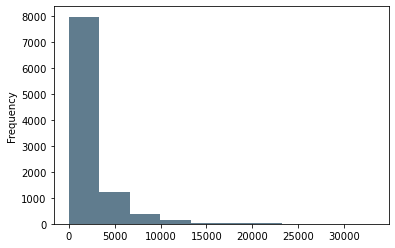

In [13]:

short_dialysis.value.plot.hist(grid=False,
                   color='#607c8e')

In [14]:
hd = short_dialysis[short_dialysis['label']=='Hemodialysis']
hd

,subject_id,hadm_id,stay_id,starttime,endtime,itemid,value,valueuom,label,category
0,19004463,24357541,39101627,2177-01-23 11:15:00,2177-01-23 14:50:00,225441,215.0,min,Hemodialysis,4-Procedures
1,19004463,24357541,39101627,2177-01-25 12:00:00,2177-01-25 15:00:00,225441,180.0,min,Hemodialysis,4-Procedures
2,19004463,24357541,39101627,2177-01-27 13:06:00,2177-01-27 16:36:00,225441,210.0,min,Hemodialysis,4-Procedures
3,19004463,24357541,39101627,2177-01-30 10:03:00,2177-02-01 01:28:00,225441,2365.0,min,Hemodialysis,4-Procedures
4,19004463,24357541,39101627,2177-02-01 09:15:00,2177-02-01 12:45:00,225441,210.0,min,Hemodialysis,4-Procedures
...,...,...,...,...,...,...,...,...,...,...
9809,13164487,21625786,38409010,2172-09-01 13:13:00,2172-09-01 16:15:00,225441,182.0,min,Hemodialysis,4-Procedures
9810,13164487,21625786,38409010,2172-09-03 09:45:00,2172-09-06 19:00:00,225441,4875.0,min,Hemodialysis,4-Procedures
9811,13164487,21625786,38409010,2172-09-07 14:06:00,2172-09-07 21:32:00,225441,446.0,min,Hemodialysis,4-Procedures
9813,13164487,21625786,39586497,2172-09-16 08:46:00,2172-09-16 12:46:00,225441,240.0,min,Hemodialysis,4-Procedures


<AxesSubplot:ylabel='Frequency'>

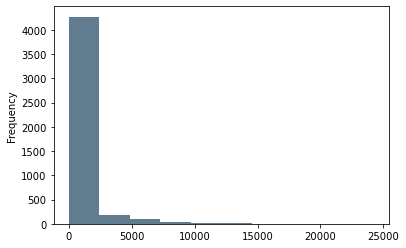

In [17]:
hd.value.plot.hist(grid=False,
                   color='#607c8e')
#hmm, some of these are too long - shouldn't have a 4000 minute HD session - should be 2-4 hours usually, so 120-240 minutes could imagine a few longer sessions too
# also some are in hours and some are in minutes 

# convert all hours to minutes
# drop all that are too long to be HD?


In [24]:
# convert all hours to minutes

#if valueuom in minutes, then value2 = value, if valueuom in hours, then value2=value*60)

#there aren't any seconds, right? 

short_dialysis.valueuom.value_counts()


min     8595
hour    1029
day      194
Name: valueuom, dtype: int64

In [25]:
short_dialysis[short_dialysis['valueuom']=='day']
#what are the values like in days? okay reasonable 

,subject_id,hadm_id,stay_id,starttime,endtime,itemid,value,valueuom,label,category
41,10916264,21525506,36789073,2145-05-10 01:05:00,2145-05-10 06:45:00,225802,0.236111,day,Dialysis - CRRT,Dialysis
74,14228169,29566561,33551009,2143-10-02 01:00:00,2143-10-04 04:34:00,225802,2.148611,day,Dialysis - CRRT,Dialysis
255,12975635,22890659,34889044,2114-11-22 07:15:00,2114-11-22 19:45:00,225802,0.520833,day,Dialysis - CRRT,Dialysis
256,12975635,22890659,34889044,2114-11-22 23:40:00,2114-11-24 15:40:00,225802,1.666667,day,Dialysis - CRRT,Dialysis
362,17595110,26348851,38452655,2129-07-03 20:30:00,2129-07-09 23:20:00,225802,6.118056,day,Dialysis - CRRT,Dialysis
...,...,...,...,...,...,...,...,...,...,...
9749,16504969,24507010,31262149,2184-11-09 15:00:00,2184-11-18 20:35:00,225802,9.232639,day,Dialysis - CRRT,Dialysis
9750,16504969,24507010,31262149,2184-11-19 00:35:00,2184-11-19 20:00:00,225802,0.809028,day,Dialysis - CRRT,Dialysis
9751,16504969,24507010,31262149,2184-11-19 23:00:00,2184-11-22 21:22:00,225802,2.931944,day,Dialysis - CRRT,Dialysis
9799,13020830,21810164,33940777,2179-01-05 12:15:00,2179-01-07 11:27:00,225802,1.966667,day,Dialysis - CRRT,Dialysis


In [26]:
short_dialysis.dtypes

subject_id             int64
hadm_id                int64
stay_id                int64
starttime     datetime64[ns]
endtime       datetime64[ns]
itemid                 int64
value                float64
valueuom              object
label                 object
category              object
dtype: object

In [27]:
short_dialysis['value'] = short_dialysis['value'].astype(np.int64)

In [28]:
short_dialysis.dtypes

subject_id             int64
hadm_id                int64
stay_id                int64
starttime     datetime64[ns]
endtime       datetime64[ns]
itemid                 int64
value                  int64
valueuom              object
label                 object
category              object
dtype: object

example if/then

def new_column(row):
    if row['COL_1'] <= row['COL_2']:
        return 1
    elif row['COL_2'] == 0:
        return -1
    else:
        return 0
    
df['RESULT'] = df.apply(new_column, axis=1)

In [29]:

#if valueuom in minutes, then value2 = value, if valueuom in hours, then value2=value*60 and if valueuom in days then value2=value*24*60

def fix_time(row):
    if row['valueuom'] == 'day':
        return row['value']*24*60
    elif row['valueuom'] == 'hour':
        return row['value']*60
    else:
        return row['value']
    

In [30]:

short_dialysis['value_minutes'] = short_dialysis.apply(fix_time, axis=1)

In [31]:
short_dialysis #yay 

,subject_id,hadm_id,stay_id,starttime,endtime,itemid,value,valueuom,label,category,value_minutes
0,19004463,24357541,39101627,2177-01-23 11:15:00,2177-01-23 14:50:00,225441,215,min,Hemodialysis,4-Procedures,215
1,19004463,24357541,39101627,2177-01-25 12:00:00,2177-01-25 15:00:00,225441,180,min,Hemodialysis,4-Procedures,180
2,19004463,24357541,39101627,2177-01-27 13:06:00,2177-01-27 16:36:00,225441,210,min,Hemodialysis,4-Procedures,210
3,19004463,24357541,39101627,2177-01-30 10:03:00,2177-02-01 01:28:00,225441,2365,min,Hemodialysis,4-Procedures,2365
4,19004463,24357541,39101627,2177-02-01 09:15:00,2177-02-01 12:45:00,225441,210,min,Hemodialysis,4-Procedures,210
...,...,...,...,...,...,...,...,...,...,...,...
9813,13164487,21625786,39586497,2172-09-16 08:46:00,2172-09-16 12:46:00,225441,240,min,Hemodialysis,4-Procedures,240
9814,17970554,21118822,33164569,2125-07-31 14:15:00,2125-08-01 15:03:00,225802,1488,min,Dialysis - CRRT,Dialysis,1488
9815,12500393,22476125,31607508,2178-01-18 11:54:00,2178-01-18 15:24:00,225441,3,hour,Hemodialysis,4-Procedures,180
9816,16073495,23252940,34992538,2115-04-06 16:56:00,2115-04-07 01:53:00,225802,537,min,Dialysis - CRRT,Dialysis,537


In [16]:
cvvh = short_dialysis[short_dialysis['label']=='Dialysis - CRRT']
cvvh

#okay, more longer sessions, that's good, though there are some random short ones but could be reasonable if circuit clots or if circuit has to be broken for studies or something 

,subject_id,hadm_id,stay_id,starttime,endtime,itemid,value,valueuom,label,category
9,11538389,22188993,37455091,2145-10-30 10:16:00,2145-11-04 06:59:00,225802,7003.0,min,Dialysis - CRRT,Dialysis
10,11538389,22188993,37455091,2145-11-02 06:00:00,2145-11-02 14:00:00,225802,480.0,min,Dialysis - CRRT,Dialysis
11,11538389,22188993,37455091,2145-11-02 15:10:00,2145-11-02 19:50:00,225802,280.0,min,Dialysis - CRRT,Dialysis
12,11538389,22188993,37455091,2145-11-02 21:00:00,2145-11-03 00:30:00,225802,210.0,min,Dialysis - CRRT,Dialysis
13,11538389,22188993,37455091,2145-11-03 02:30:00,2145-11-03 10:30:00,225802,480.0,min,Dialysis - CRRT,Dialysis
...,...,...,...,...,...,...,...,...,...,...
9805,10678253,25525077,35352739,2129-03-07 01:00:00,2129-03-12 15:01:00,225802,8041.0,min,Dialysis - CRRT,Dialysis
9812,13372200,26628430,31196251,2121-08-26 21:00:00,2121-08-30 11:05:00,225802,5165.0,min,Dialysis - CRRT,Dialysis
9814,17970554,21118822,33164569,2125-07-31 14:15:00,2125-08-01 15:03:00,225802,1488.0,min,Dialysis - CRRT,Dialysis
9816,16073495,23252940,34992538,2115-04-06 16:56:00,2115-04-07 01:53:00,225802,537.0,min,Dialysis - CRRT,Dialysis


<AxesSubplot:ylabel='Frequency'>

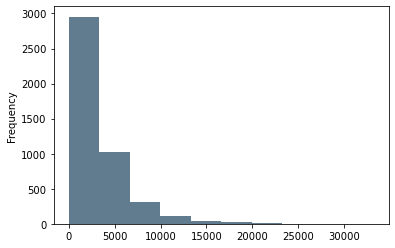

In [18]:
cvvh.value.plot.hist(grid=False,
                   color='#607c8e')

In [20]:
#let's zoom in on one person - 22188993

example = short_dialysis[short_dialysis['hadm_id']==22188993]
example

,subject_id,hadm_id,stay_id,starttime,endtime,itemid,value,valueuom,label,category
9,11538389,22188993,37455091,2145-10-30 10:16:00,2145-11-04 06:59:00,225802,7003.0,min,Dialysis - CRRT,Dialysis
10,11538389,22188993,37455091,2145-11-02 06:00:00,2145-11-02 14:00:00,225802,480.0,min,Dialysis - CRRT,Dialysis
11,11538389,22188993,37455091,2145-11-02 15:10:00,2145-11-02 19:50:00,225802,280.0,min,Dialysis - CRRT,Dialysis
12,11538389,22188993,37455091,2145-11-02 21:00:00,2145-11-03 00:30:00,225802,210.0,min,Dialysis - CRRT,Dialysis
13,11538389,22188993,37455091,2145-11-03 02:30:00,2145-11-03 10:30:00,225802,480.0,min,Dialysis - CRRT,Dialysis
14,11538389,22188993,37455091,2145-11-03 11:10:00,2145-11-04 07:02:00,225802,1192.0,min,Dialysis - CRRT,Dialysis
15,11538389,22188993,37455091,2145-11-05 14:57:00,2145-11-06 03:15:00,225802,738.0,min,Dialysis - CRRT,Dialysis
16,11538389,22188993,37455091,2145-11-06 12:45:00,2145-11-07 01:03:00,225802,738.0,min,Dialysis - CRRT,Dialysis
17,11538389,22188993,37455091,2145-11-07 03:00:00,2145-11-07 13:00:00,225802,600.0,min,Dialysis - CRRT,Dialysis


In [21]:

example = short_dialysis[short_dialysis['hadm_id']==24357541]
example
#yeah, that one 2365 min dialysis session is probably a mistake

#also, how to translate this start/end into each day? 

,subject_id,hadm_id,stay_id,starttime,endtime,itemid,value,valueuom,label,category
0,19004463,24357541,39101627,2177-01-23 11:15:00,2177-01-23 14:50:00,225441,215.0,min,Hemodialysis,4-Procedures
1,19004463,24357541,39101627,2177-01-25 12:00:00,2177-01-25 15:00:00,225441,180.0,min,Hemodialysis,4-Procedures
2,19004463,24357541,39101627,2177-01-27 13:06:00,2177-01-27 16:36:00,225441,210.0,min,Hemodialysis,4-Procedures
3,19004463,24357541,39101627,2177-01-30 10:03:00,2177-02-01 01:28:00,225441,2365.0,min,Hemodialysis,4-Procedures
4,19004463,24357541,39101627,2177-02-01 09:15:00,2177-02-01 12:45:00,225441,210.0,min,Hemodialysis,4-Procedures
5,19004463,24357541,39101627,2177-02-03 13:05:00,2177-02-03 15:00:00,225441,115.0,min,Hemodialysis,4-Procedures
6,19004463,24357541,39101627,2177-02-05 13:08:00,2177-02-05 16:05:00,225441,177.0,min,Hemodialysis,4-Procedures
7,19004463,24357541,39101627,2177-02-08 17:12:00,2177-02-08 19:20:00,225441,128.0,min,Hemodialysis,4-Procedures
8,19004463,24357541,39101627,2177-02-12 15:03:00,2177-02-12 21:41:00,225441,398.0,min,Hemodialysis,4-Procedures


In [36]:
short_dialysis[(short_dialysis['label']=='Hemodialysis') & (short_dialysis['value_minutes']>360)]
#hmm, there are a lot of long dialysis; I wonder if some of these were just incorrectly charted as hemodialysis and should be CVVH? no way to tell for sure I think


,subject_id,hadm_id,stay_id,starttime,endtime,itemid,value,valueuom,label,category,value_minutes
3,19004463,24357541,39101627,2177-01-30 10:03:00,2177-02-01 01:28:00,225441,2365,min,Hemodialysis,4-Procedures,2365
8,19004463,24357541,39101627,2177-02-12 15:03:00,2177-02-12 21:41:00,225441,398,min,Hemodialysis,4-Procedures,398
18,15110026,28089871,38700117,2142-03-27 13:15:00,2142-03-28 16:59:00,225441,1664,min,Hemodialysis,4-Procedures,1664
19,18553055,25242305,37779784,2186-09-27 09:43:00,2186-09-27 16:32:00,225441,409,min,Hemodialysis,4-Procedures,409
37,12199246,25482501,33794813,2179-07-28 11:07:00,2179-07-29 14:37:00,225441,1650,min,Hemodialysis,4-Procedures,1650
...,...,...,...,...,...,...,...,...,...,...,...
9720,17304212,29292229,38138468,2154-04-10 13:20:00,2154-04-14 10:09:00,225441,5569,min,Hemodialysis,4-Procedures,5569
9745,17810811,25877275,30529254,2138-10-12 21:30:00,2138-10-19 08:00:00,225441,9270,min,Hemodialysis,4-Procedures,9270
9795,18836076,27501324,33811360,2129-05-04 18:41:00,2129-05-06 06:08:00,225441,2127,min,Hemodialysis,4-Procedures,2127
9810,13164487,21625786,38409010,2172-09-03 09:45:00,2172-09-06 19:00:00,225441,4875,min,Hemodialysis,4-Procedures,4875


I posted a question about this in the MIMIC-IV github - https://github.com/MIT-LCP/mimic-code/discussions/1259


In [35]:
short_dialysis.dtypes

subject_id                int64
hadm_id                   int64
stay_id                   int64
starttime        datetime64[ns]
endtime          datetime64[ns]
itemid                    int64
value                     int64
valueuom                 object
label                    object
category                 object
value_minutes             int64
dtype: object

In [37]:
short_dialysis.head()

,subject_id,hadm_id,stay_id,starttime,endtime,itemid,value,valueuom,label,category,value_minutes
0,19004463,24357541,39101627,2177-01-23 11:15:00,2177-01-23 14:50:00,225441,215,min,Hemodialysis,4-Procedures,215
1,19004463,24357541,39101627,2177-01-25 12:00:00,2177-01-25 15:00:00,225441,180,min,Hemodialysis,4-Procedures,180
2,19004463,24357541,39101627,2177-01-27 13:06:00,2177-01-27 16:36:00,225441,210,min,Hemodialysis,4-Procedures,210
3,19004463,24357541,39101627,2177-01-30 10:03:00,2177-02-01 01:28:00,225441,2365,min,Hemodialysis,4-Procedures,2365
4,19004463,24357541,39101627,2177-02-01 09:15:00,2177-02-01 12:45:00,225441,210,min,Hemodialysis,4-Procedures,210


In [32]:
short_dialysis.to_csv("dialysis2-21-22.csv")